In [1]:
import os
os.chdir("..")
print(os.getcwd())

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import glob
import copy

%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.utils.vis_utils import combine_tb_logs

/u/clw4542/research/marl/adaptive_marl/baselines/pymarl


In [331]:
# append base paths
base_paths = {"ippo": "/scratch/cluster/clw4542/marl_results/ippo_{}/tb_logs",
              "qmix": "/scratch/cluster/clw4542/marl_results/qmix_{}/tb_logs",
              "rmappo": "/scratch/cluster/clw4542/marl_results/rmappo_{}/tb_logs"
             }

demo_win_rate = {
    "5v6": {
#         "ippo demo (1m)": 0., 
#         "ippo demo (2m)": 0.007874015718698502, 
#         "ippo demo (3m)": 0.0, 
#         "ippo demo (4m)": 0.015748031437397003,
#         "ippo demo (5m)": 0.12598425149917603, # NEW 
        "ippo demo (5m)": 0.30952380952380953,# OLD
#         "ippo demo (6m)": 0.22047244012355804,
#         "ippo demo (7m)": 0.4409448802471161, # NEW
        "ippo demo (7m)": 0.48412698412698413,# OLD
#         "ippo demo (8m)": 0.4094488322734833,
#         "ippo demo (9m)": 0.5196850299835205, 
#         "dippo demo (10m)": 0.5826771855354309,
        "qmix demo": 0.7051768938636818, # eps=0
#         "qmix demo, eps=0.025": 0.49217391304347824 # eps=0.025
           },
    "3sv4z": {
#         "ippo demo (1m)": 0., 
#         "ippo demo (2m)": 0., 
#         "ippo demo (3m)": 0.007874015718698502, 
#         "ippo demo (4m)": 0.06299212574958801,
#         "ippo demo (5m)": 0.3385826647281647, # NEW
        "ippo demo (5m)": 0.35714285714285715, # OLD
#         "ippo demo (6m)": 0.5118110179901123, # NEW
        "ippo demo (6m)":0.5634920634920635, # OLD
#         "ippo demo (7m)": 0.6535432934761047,
#         "ippo demo (8m)": 0.6771653294563293,
#         "ippo demo (9m)": 0.8110235929489136, 
#         "demo-ts=10m": 0.8976377844810486,
        "qmix demo": 0.9956681106297901, # eps = 0
#          "qmix demo": 0.8023255813953488 # eps = 0.05
        
    },
    "3sv3z": {
        "ippo demo (10m)": 1.0, # PLACEHOLDER
#         "qmix demo": 0.9993335554815062, # eps=0
        "qmix demo": 0.8888888888888888, # eps=0.1
#         "qmix demo, eps=0.2": 0.7647058823529411 # eps=0.2
        
    },
    "3sv5z": {
        "ippo demo (10m)": 0.0,
#         "qmix demo": 0.9446851049650117, # eps=0
#         "qmix demo": 0.8571428571428571, # eps=0.03
        "qmix demo": 0.23214285714285715 # eps=0.1
        
    },
    "8v9": {
        "ippo demo (10m)": 0.4, # PLACEHOLDER
#        "qmix demo": 0.9452910317262053, # eps = 0
#        "qmix demo": 0.7362542955326461 # eps = 0.05
        "qmix demo": 0.38254410399257194, # eps = 0.1
    }
}

In [164]:
# construct baselines expt dict
# dict structure: algo name, task name, experiment name
baselines = {}
baseline_names = {"qmix": ["qmix_sc2_baseline-fc=2__seed=*", "qmix_sc2_baseline__seed=*"], 
#               "qmix": ["qmix_sc2_baseline-fc=3__seed=*"], 
                 "ippo": ["ippo_sc2_baseline_seed*"],
                 "rmappo": ["rmappo_sc2_baseline-orig-all_seed=*"]
             }
for algo_name in ["qmix", "ippo", "rmappo"]:
    baselines[algo_name] = {}
#     for task_name, task_basename in task_names.items():
    for task_name in ["5v6", "3sv4z", 
                      "3sv3z", "3sv5z", "8v9"
                     ]:
        log_basenames = baseline_names[algo_name]
        results = []
        for logname in log_basenames:
            results += glob.glob(os.path.join(base_paths[algo_name].format(task_name),
                                     logname
                                     ))         
        baselines[algo_name][task_name] = {f"{algo_name} baseline": results}
baselines.keys()

dict_keys(['qmix', 'ippo', 'rmappo'])

### Plotting Functions

In [165]:
def gen_log_data(experiments:dict):
    exp_dfs = {}
    for exp_name, exp_files_list in experiments.items():
        if "ippo" in exp_name.lower(): 
            stat_name = "test_ippo_battle_won_mean"
        elif "dm2" in exp_name.lower():
            stat_name = "test_ippo_battle_won_mean"            
        elif "qmix" in exp_name.lower(): 
            stat_name = "test_qmix_battle_won_mean"
        elif "rmappo" in exp_name.lower():
            stat_name = "eval_win_rate"
        else:
            stat_name = "test_ippo_battle_won_mean"

        res_dict = combine_tb_logs(exp_files_list, stat_name, ts_round_base=5e+4)
        
        # trim logs
        log_lens = []
        for k, v in res_dict.items():
            log_lens.append(len(v))
        min_log_len = min(log_lens)

        for k, v in res_dict.items():
            res_dict[k] = v[:min_log_len]
        
        # convert to dataframe
        df = pd.DataFrame.from_dict(res_dict, orient='columns')
        df = df.melt(id_vars="ts", var_name="runs", value_name="test_battle_won_mean")
        
        exp_dfs[exp_name] = df

    return exp_dfs

In [325]:
# def core_plots(exp_dfs:dict, demo_qual:dict, )
def plot_experiments(exp_dfs:dict, 
                     savename:str, 
                     plot_title:str=None, 
                     legend=True,
                     legend_cols=4,
                     legend_loc=(1.0, -0.25),
                     demo_qual:dict=None, 
                     yaxis_lims=None,
                     custom_color_order=None,
                     save=False, 
                     savedir="figures/"):
#     sns.set_theme(style="wgrid")
    sns.set_context("paper")
    sns.set(font_scale = 1.5)
    
    if custom_color_order is None:
        custom_color_order = list(range(len(exp_dfs)))

    baseline_palette = list(sns.color_palette("Oranges", as_cmap=False, n_colors=7).as_hex())
    dm2_palette = list(sns.color_palette("mako", as_cmap=False, n_colors=12).as_hex())
    gail_palette = list(sns.color_palette("BuPu", as_cmap=False, n_colors=7, desat=0.7).as_hex())
    default_palette = sns.color_palette("colorblind", as_cmap=True)

    figure, axis = plt.subplots(1, 1, figsize=(7, 5)) # figsize argument
    for i, (exp_name, exp_df) in enumerate(exp_dfs.items()):
        if "baseline" in exp_name: 
            color = baseline_palette.pop()
            baseline_palette.pop()
        elif "dm2" in exp_name: 
            color = dm2_palette[i*2 + 3]
        elif "gail" in exp_name:
            color = gail_palette.pop()
            gail_palette.pop()
        else: 
            color = default_palette[i]
        sns.lineplot(data = exp_df, x="ts", y="test_battle_won_mean", 
                     ci="sd", ax=axis, label=exp_name, 
                     color=color,
                    )
        
    axis.set_xlabel("Timesteps")
    axis.set_ylabel("Mean Battle Won Rate")
    if yaxis_lims is not None:
        axis.set_ylim(yaxis_lims)
    if plot_title is not None:
        axis.set_title(plot_title)

    if demo_qual is not None:
        color_list = ["darkslategray", "slateblue", "darkslateblue", "indigo", "darkviolet"]
        # from https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
        linestyle_list = [
             ('densely dashed',        (0, (5, 1))),
             ('loosely dotted',        (0, (1, 10))),
             ('dotted',                (0, (1, 1))),
             ('loosely dashed',        (0, (5, 10))),
             ('long dash with offset', (5, (10, 3))),
              ]
        for i, (demo_name, demo_quality) in enumerate(demo_qual.items()):
            plt.axhline(y=demo_quality, xmin=0.05, xmax=0.95, 
                        color=color_list[0], # figure_colors[i+1], 
                        linestyle= linestyle_list.pop(-1)[1], 
                        label=demo_name
                       )
    if legend:
        plt.legend( 
                   bbox_to_anchor=legend_loc, 
                   borderaxespad=0.,
                   ncol=legend_cols,
                   fontsize=13
                  )
    else:
        leg = axis.get_legend()
        leg.remove()
    
#     plt.tight_layout()
    if save:
        if not os.path.exists(savedir):
            os.mkdir("figures")            
        savepath = os.path.join(savedir, savename + ".pdf")
        
        print(f"Saving to {savepath}")
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

In [156]:
# See https://seaborn.pydata.org/tutorial/color_palettes.html 
# for list of color palettes and meaning of parameters
pal = sns.color_palette("colorblind", as_cmap=False).as_hex()
pal

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

## Core Results

In [167]:
# dm2 core result experiment dict
ippo_base_path = "/scratch/cluster/clw4542/marl_results/ippo_{}/tb_logs"
task_names = {# task_folder: basename_regex
         "3sv4z": "ippo_sc2_rew-type=mixed-exp-ts={}-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=*", 
         "5v6": "ippo_sc2_rew-type=mixed-exp-ts={}-demos=concurrent-exp-policies=all-same_seed=*",
         "3sv3z": "ippo_sc2_rew-type=mixed-gail-coef=0.3-demo=ippo-demo-ts={}_seed=*",
#          "3sv3z_c=0.5": "ippo_sc2_rew-type=mixed-gail-coef=0.5-demo=ippo-demo-ts={}_seed=*",
         "3sv5z": "ippo_sc2_rew-type=mixed-gail-coef=0.1-demo=ippo-demo-ts={}_seed=*",
#          "3sv5z_c=0.3": "ippo_sc2_rew-type=mixed-gail-coef=0.3-demo=ippo-demo-ts={}_seed=*",
         "8v9": "ippo_sc2_rew-type=mixed-gail-coef=0.4-demo=ippo-demo-ts={}_seed=*",
#          "8v9_c=0.6": "ippo_sc2_rew-type=mixed-gail-coef=0.6-demo=ippo-demo-ts={}_seed=*",
#          "8v9_c=0.8": "ippo_sc2_rew-type=mixed-gail-coef=0.8-demo=ippo-demo-ts={}_seed=*"
#          "8v9": "ippo_sc2_rew-type=mixed-gail-coef=0.8-demo=ippo-demo-ts={}_seed=*",
#          "8v9_c=1.0": "ippo_sc2_rew-type=mixed-gail-coef=1.0-demo=ippo-demo-ts={}_seed=*"
         }
timesteps = ["1m", "2m", "3m", "4m", "5m", "6m", "7m", "8m", "9m", "10m"
            ]

experiments_core = {}
for task_name, task_basename in task_names.items():
    experiments_core[task_name] = {}
    task_folder = task_name.split("_")[0]
    for ts in timesteps:
        results = glob.glob(os.path.join(ippo_base_path.format(task_folder), task_basename.format(ts)))
        experiments_core[task_name][ts] = {f"dm2, ippo demo ({ts})": results}
experiments_core.keys()

dict_keys(['3sv4z', '5v6', '3sv3z', '3sv5z', '8v9'])

In [168]:
# dm2 w/qmix demos experiment dict
ippo_base_path = "/scratch/cluster/clw4542/marl_results/ippo_{}/tb_logs"
task_names = {# task_folder: basename_regex
         "3sv4z": "ippo_sc2_rew-type=mixed-demo=qmix-demos=concurrent-exp-policies=all-same_seed=*", 
#          "3sv4z": "ippo_sc2_rew-type=mixed-demo=qmix-demos=concurrent-exp-policies=all-same-eps=0.05_seed=*", 
         "5v6": "ippo_sc2_rew-type=mixed-demo=qmix-demos=concurrent-exp-policies=all-same_seed=*",
#          "5v6": "ippo_sc2_rew-type=mixed-demo=qmix-demos=concurrent-exp-policies=all-same-eps=0.025_seed=*",
#         "3sv3z_c=0.3": "ippo_sc2_rew-type=mixed-gail-coef=0.3-demos=qmix_seed=*",
        "3sv3z": "ippo_sc2_rew-type=mixed-gail-coef=0.3-demos=qmix-eps=0.1_seed=*",
#          "3sv3z_c=0.5": "ippo_sc2_rew-type=mixed-gail-coef=0.5-demos=qmix_seed=*",
#          "3sv5z": "ippo_sc2_rew-type=mixed-gail-coef=0.1-demos=qmix_seed=*",
#          "3sv5z_c=0.3": "ippo_sc2_rew-type=mixed-gail-coef=0.3-demos=qmix_seed=*",
#         "3sv5z_eps=0.03": "ippo_sc2_rew-type=mixed-gail-coef=0.1-demos=qmix-eps=0.03_seed=*",
        "3sv5z": "ippo_sc2_rew-type=mixed-gail-coef=0.1-demos=qmix-eps=0.1_seed=*",
#         "8v9_eps=0.05": "ippo_sc2_rew-type=mixed-gail-coef=0.4-demos=qmix-eps=0.05_seed=*",
        "8v9": "ippo_sc2_rew-type=mixed-gail-coef=0.4-demos=qmix-eps=0.1_seed=*",
#       "8v9_c=1.0": "ippo_sc2_rew-type=mixed-gail-coef=1.0-demos=qmix_seed=*"
#       "8v9_c=0.8": "ippo_sc2_rew-type=mixed-gail-coef=0.8-demos=qmix_seed=*",

}
experiments_qmix_demo = {}
for task_name, task_basename in task_names.items():
    experiments_qmix_demo[task_name] = {}
    task_folder = task_name.split("_")[0]
    results = glob.glob(os.path.join(ippo_base_path.format(task_folder), task_basename))
    experiments_qmix_demo[task_name] = {f"dm2, qmix demo": results}
experiments_qmix_demo.keys()

dict_keys(['3sv4z', '5v6', '3sv3z', '3sv5z', '8v9'])

In [169]:
# dm2 w/sil experiment dict
ippo_base_path = "/scratch/cluster/clw4542/marl_results/ippo_{}/tb_logs"
task_names = {# task_folder: basename_regex
         "3sv4z": "ippo_sc2_rew-type=mixed-sil-gail-buffer-size=1024_seed=*", 
         "5v6": "ippo_sc2_rew-type=mixed-sil-gail-buffer-size=1024_seed=*",
         "3sv3z": "ippo_sc2_rew-type=mixed-sil-gail-buffer-size=1024_seed=*",
         "3sv5z": "ippo_sc2_rew-type=mixed-sil-gail-buffer-size=1024_seed=*",
         "8v9": "ippo_sc2_rew-type=mixed-sil-gail-buffer-size=1024_seed=*",
}
experiments_sil = {}
for task_name, task_basename in task_names.items():
    experiments_sil[task_name] = {}
    task_folder = task_name.split("_")[0]
    results = glob.glob(os.path.join(ippo_base_path.format(task_folder), task_basename))
    experiments_sil[task_name] = {f"dm2, sil": results}
experiments_sil.keys()

dict_keys(['3sv4z', '5v6', '3sv3z', '3sv5z', '8v9'])

Saving to figures/aaai_camera-ready/3sv3z_core_exp.pdf


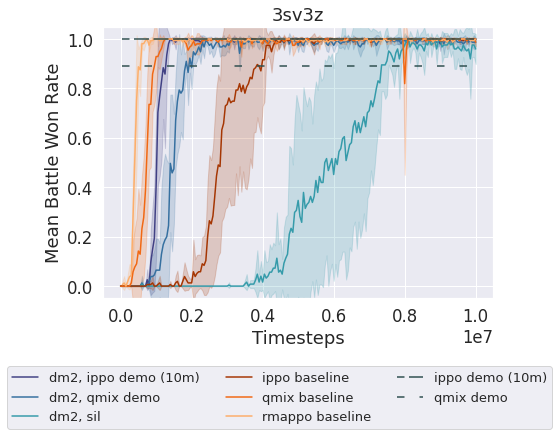

Saving to figures/aaai_camera-ready/3sv5z_core_exp.pdf


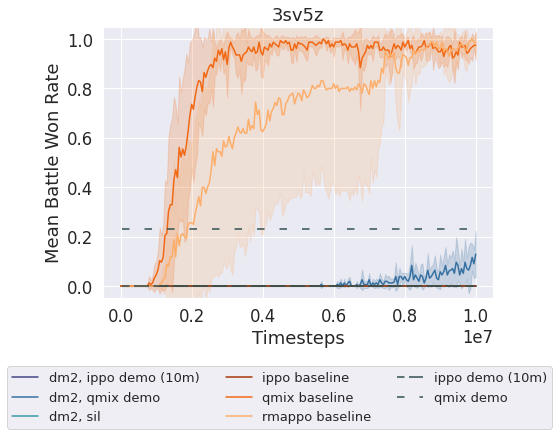

Saving to figures/aaai_camera-ready/8v9_core_exp.pdf


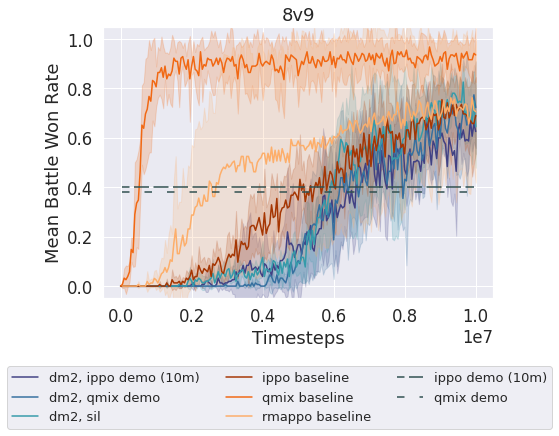

In [333]:
# plot all results
task_demo_dict = {
#                   "5v6": ["5m", "7m"],
#                   "3sv4z": ["5m", "6m"],
                  "3sv3z": ["10m"],
                  "3sv5z": ["10m"], 
                  "8v9": ["10m"],

}
for task_name, demo_ts in task_demo_dict.items():
    experiments = {}
    task_base = task_name.split("_")[0]
    for ts in demo_ts:
        experiments = {
            **experiments,
            **experiments_core[task_base][ts],
        }

    experiments = {
                  **experiments,
                   **experiments_qmix_demo[task_name],
                   **experiments_sil[task_name],
                   **baselines["ippo"][task_base], 
                   **baselines["qmix"][task_base], 
                   **baselines["rmappo"][task_base],
    }
    
    exp_dfs = gen_log_data(experiments)
    
    plot_experiments(exp_dfs, 
                 plot_title=f"{task_name}",
                 savename=f"{task_name}_core_exp", #"qmix policies"
                 demo_qual=demo_win_rate[task_base],
                 custom_color_order=[2,1,3,0,4, 5],
                 legend_cols=3,
                 legend_loc=(1.15, -0.25),
                 yaxis_lims=(-0.05, 1.05),
                 save=True,
                 savedir="figures/aaai_camera-ready/")


## Comparison against GAIL only Reward

In [181]:
# gail-only reward experiment dict
ippo_base_path = "/scratch/cluster/clw4542/marl_results/ippo_{}/tb_logs"
task_names = {# task_folder: basename_regex
         "3sv4z": "ippo_sc2_rew-type=gail-exp-ts={}-demos=concurrent-exp-policies=all-same_seed=*", 
         "5v6": "ippo_sc2_rew-type=gail-exp-ts={}-demos=concurrent-exp-policies=all-same_seed=*",
         }

timesteps = ["1m", "2m", "3m", "4m", "5m", "6m", "7m", "8m", "9m", "10m"]

experiments_gail_only = {}
for task_name, task_basename in task_names.items():
    experiments_gail_only[task_name] = {}
    task_folder = task_name.split("_")[0]
    for ts in timesteps:
        results = glob.glob(os.path.join(ippo_base_path.format(task_folder), task_basename.format(ts)))
        experiments_gail_only[task_name][ts] = {f"ippo w/gail rew, ippo demo ({ts})": results}
experiments_gail_only.keys()

dict_keys(['3sv4z', '5v6'])

Saving to figures/aaai_camera-ready/5v6_gail-effect_exp.pdf


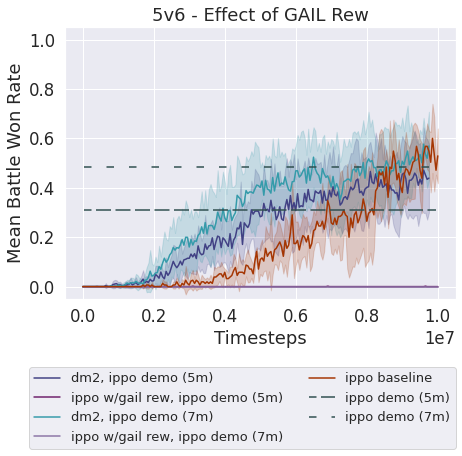

Saving to figures/aaai_camera-ready/3sv4z_gail-effect_exp.pdf


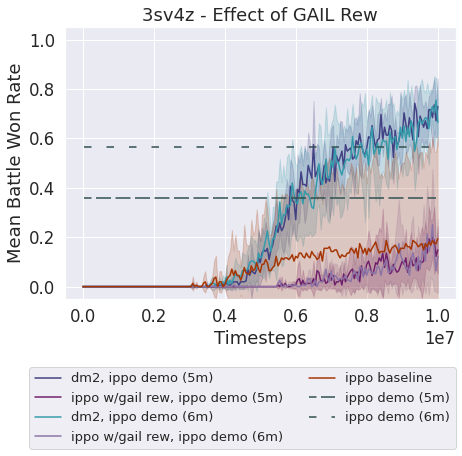

In [226]:
task_demo_dict = {
                  "5v6": ["5m", "7m"],
                  "3sv4z": ["5m", "6m"],
                 }
for task_name, demo_ts in task_demo_dict.items():
    task_base = task_name.split("_")[0]
    experiments = {}
    for ts in demo_ts:
        experiments = {
            **experiments,
            **experiments_core[task_name][ts],
            **experiments_gail_only[task_name][ts],
        }
    
    experiments = {**experiments, 
                   **baselines["ippo"][task_base], 
                  }

    exp_dfs = gen_log_data(experiments)   
    demo_qual = copy.deepcopy(demo_win_rate[task_base])
    del demo_qual["qmix demo"]
    plot_experiments(exp_dfs, 
                 plot_title=f"{task_name} - Effect of GAIL Rew",
                 savename=f"{task_name}_gail-effect_exp", #"qmix policies"
                 demo_qual=demo_qual,
                 custom_color_order=[2, 1, 3, 0, 4, 5],
                 legend_cols=2,
                 yaxis_lims=(-0.05, 1.05),
                 save=True, 
                 savedir="figures/aaai_camera-ready/")


## Comparison with BC Pretraining

In [227]:
# bc pretraining w/ippo
ippo_base_path = "/projects/agents6/caroline/ishan_exp/bc_ippo_{}/tb_logs"
task_names = {# task_folder: basename_regex
         "3sv4z": "ippo_sc2_bc-pretraining_seed=*", 
         "5v6": "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=*",
         }
ts = "5m"
experiments_bc_ippo = {}
for task_name, task_basename in task_names.items():
    experiments_bc_ippo[task_name] = {}
    task_folder = task_name.split("_")[0]
    results = glob.glob(os.path.join(ippo_base_path.format(task_folder), task_basename))
    experiments_bc_ippo[task_name][ts] = {"ippo w/bc pretrain": results}
experiments_bc_ippo.keys()

dict_keys(['3sv4z', '5v6'])

In [228]:
# bc pretraining w/dm2
ippo_base_path = "/projects/agents6/caroline/ishan_exp/bc_mixed_results/sacred/"
task_names = {# task_folder: basename_regex
         "3sv4z":  ['1', '2', '3', '4'],
         "5v6":  ['5', '6', '7', '8']
         }
ts = "5m"
experiments_bc_dm2 = {}
for task_name, task_basenames in task_names.items():
    experiments_bc_dm2[task_name] = {}
    results = [os.path.join(ippo_base_path, base) for base in task_basenames]

    task_folder = task_name.split("_")[0]
    experiments_bc_dm2[task_name][ts] = {"dm2 w/bc pretrain": results}
experiments_bc_dm2.keys()

dict_keys(['3sv4z', '5v6'])

Saving to figures/aaai_camera-ready/5v6_bc-pretrain_exp.pdf


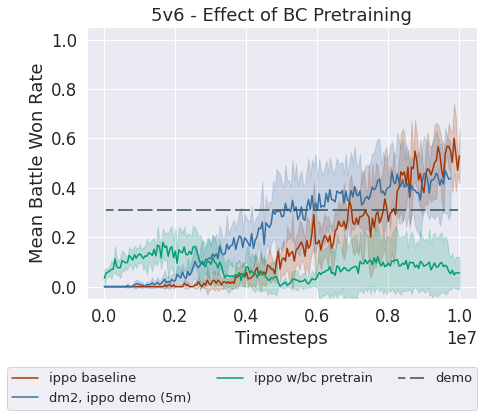

Saving to figures/aaai_camera-ready/3sv4z_bc-pretrain_exp.pdf


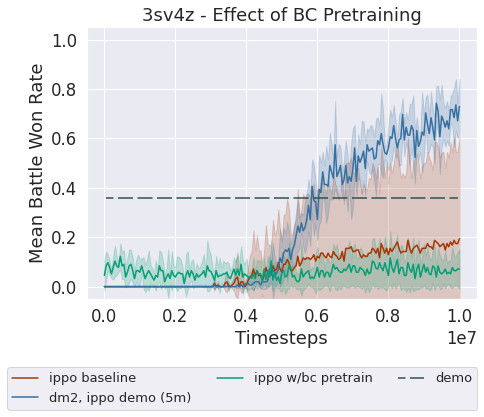

In [231]:
task_demo_dict = {
                  "5v6": ["5m"],
                  "3sv4z": ["5m"],
                 }
for task_name, demo_ts in task_demo_dict.items():
    task_base = task_name.split("_")[0]
    experiments = {
                   **baselines["ippo"][task_base], 
                  }
    experiments_gail_only
    for ts in demo_ts:
        experiments = {
            **experiments,
            **experiments_core[task_name][ts],
            **experiments_bc_ippo[task_name][ts],
#             **experiments_bc_dm2[task_name][ts]
        }
    
    exp_dfs = gen_log_data(experiments)    
    demo_qual = {"demo": demo_win_rate[task_base]["ippo demo (5m)"]}
    plot_experiments(exp_dfs, 
                 plot_title=f"{task_name} - Effect of BC Pretraining",
                 savename=f"{task_name}_bc-pretrain_exp", #"qmix policies"
                 demo_qual=demo_qual,
                 custom_color_order=[2,1,3,0,4, 5],
                 legend_cols=3,
                 yaxis_lims=(-0.05, 1.05),
                 save=True,
                 savedir="figures/aaai_camera-ready/")


## DM2 with all Demo Timesteps

In [294]:
dm2_palette = sns.cubehelix_palette(start=0.8, 
                                    rot=-1, 
                                    light=0.7, dark=0.3,
                                    n_colors=len(exp_dfs)
                                    ).as_hex()
dm2_palette

['#a7c08c',
 '#93bb85',
 '#82b582',
 '#72ae81',
 '#62a582',
 '#579b84',
 '#4e9086',
 '#488487',
 '#447587',
 '#426784',
 '#41597f',
 '#414a75']

In [318]:
def plot_all_demo_experiments(exp_dict:dict, 
                     savename:str, 
                     plot_title:str=None, 
                     legend=True,
                     legend_cols=4,
                     demo_qual:dict=None, 
                     bbox_loc=None,
                     save=False, 
                     savedir="figures/"):
    sns.set_context("paper")
    sns.set(font_scale = 1.25)
    
    figure, axes = plt.subplots(1, 2, figsize=(14, 5)) # figsize argument
    default_palette = sns.color_palette("colorblind", as_cmap=True)
    
    for j, (task, exp_dfs) in enumerate(exp_dict.items()):
        dm2_palette = sns.cubehelix_palette(start=.8, rot=-1, 
                                            light=0.7, dark=0.3,
                                            n_colors=len(exp_dfs)
                                            ).as_hex()
        num_baselines = 0
        for i, (exp_name, exp_df) in enumerate(exp_dfs.items()):
            if exp_name == "ippo baseline": 
                color = "peru"
                num_baselines +=1 
            elif exp_name == "qmix baseline": 
                color = "sienna"
                num_baselines += 1
            elif "dm2" in exp_name: 
                color = dm2_palette[i]
            else: 
                color = default_palette[i]
            sns.lineplot(data=exp_df, x="ts", y="test_battle_won_mean", 
                         ci="sd", ax=axes[j], label=exp_name, 
                         color=color
                        )

        axes[j].set_xlabel("Timesteps")
        axes[j].set_ylabel("Mean Battle Won Rate")
        axes[j].set_ylim((-0.05, 1.05))
        axes[j].set_title(task)

        for i, (demo_name, demo_quality) in enumerate(demo_qual[task].items()):
            axes[j].axhline(y=demo_quality, xmin=0.05, xmax=0.95, 
                            color=dm2_palette[i+num_baselines], 
                            linestyle="--", 
                            label=demo_name
                           )
    # handle legend
    axes[0].legend( 
               bbox_to_anchor=bbox_loc, 
               borderaxespad=0.,
               ncol=legend_cols,
               fontsize=13
              )
    for i in range(len(exp_dict.keys()) -1):
        leg = axes[i+1].get_legend()
        leg.remove()
    
    if plot_title is not None:
        plt.title(plot_title)

    figure.subplots_adjust(wspace=0.4)

    if save:
        if not os.path.exists(savedir):
            os.mkdir("figures")            
        savepath = os.path.join(savedir, savename + ".pdf")
        
        print(f"Saving to {savepath}")
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

In [296]:
demo_qual = {
    "5v6": {
        "ippo demo (1m)": 0., 
        "ippo demo (2m)": 0.007874015718698502, 
        "ippo demo (3m)": 0.0, 
        "ippo demo (4m)": 0.015748031437397003,
        "ippo demo (5m)": 0.12598425149917603, # diff run than core result
        "ippo demo (6m)": 0.22047244012355804,
        "ippo demo (7m)": 0.4409448802471161, # diff run than core result
        "ippo demo (8m)": 0.4094488322734833,
        "ippo demo (9m)": 0.5196850299835205, 
        "ippo demo (10m)": 0.5826771855354309,
           },
    "3sv4z": {
        "ippo demo (1m)": 0., 
        "ippo demo (2m)": 0., 
        "ippo demo (3m)": 0.007874015718698502, 
        "ippo demo (4m)": 0.06299212574958801,
        "ippo demo (5m)": 0.3385826647281647, # diff run than core result
        "ippo demo (6m)": 0.5118110179901123, # diff run than core result
        "ippo demo (7m)": 0.6535432934761047,
        "ippo demo (8m)": 0.6771653294563293,
        "ippo demo (9m)": 0.8110235929489136, 
        "ippo demo (10m)": 0.8976377844810486,
    }
}

exp_dict = {}
for task in ["5v6", "3sv4z"]:
    demo_ts= ["1m", "2m", "3m", "4m", "5m", "6m", "7m", "8m", "9m", "10m"]

    experiments = {**baselines["ippo"][task],   
                   **baselines["qmix"][task]}
    for ts in demo_ts:
        experiments = {**experiments,
                       **experiments_core[task][ts]}
    exp_dict[task] = gen_log_data(experiments)    

Saving to figures/aaai_camera-ready/core_exp_all-demo-ts.pdf


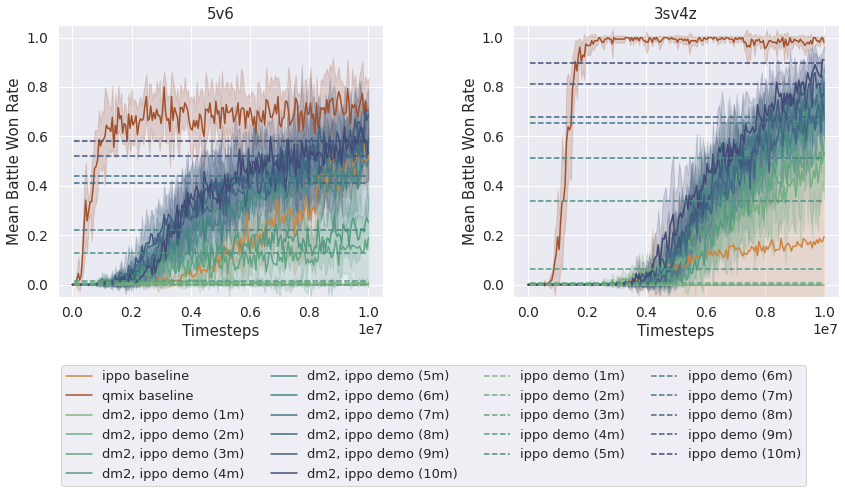

In [324]:
plot_all_demo_experiments(exp_dict, 
                          savename=f"core_exp_all-demo-ts", 
                          demo_qual=demo_qual,
                          legend_cols=4,
                          bbox_loc=(2.3, -0.25),
                          save=True,
                          savedir="figures/aaai_camera-ready/"
                )

## Demonstration Ablations

In [222]:
# construct ablations experiment dict
# dict structure: task name, demo timestep, experiment name
experiments_ablations = {
    "5v6": {
        "5m": {
             "dm2 (concur., joint)": [
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same_seed=112358_01-17-22-37-49",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same_seed=119527_01-17-22-37-49",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same_seed=122529_01-17-22-37-49",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same_seed=1285842_01-17-22-37-49",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same_seed=78590_01-17-22-37-49"
             ],
            "concur., indep.": [
                "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-diff_seed=112358_01-18-22-11-22",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-diff_seed=119527_01-18-22-15-50",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-diff_seed=122529_01-18-22-16-27",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-diff_seed=1285842_01-18-22-13-38",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-diff_seed=78590_01-18-22-15-11"
                                                 ],
             "nonconcur., indep.": [
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=nonconcurrent-exp-policies=all-diff_seed=112358_01-18-12-38-16",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=nonconcurrent-exp-policies=all-diff_seed=119527_01-18-12-38-16",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=nonconcurrent-exp-policies=all-diff_seed=122529_01-18-12-38-16",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=nonconcurrent-exp-policies=all-diff_seed=1285842_01-18-12-38-16",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=nonconcurrent-exp-policies=all-diff_seed=78590_01-18-12-38-16"
             ],
             "nonconcur., joint": [
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=nonconcurrent-exp-policies=all-same_seed=112358_01-17-22-48-20",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=nonconcurrent-exp-policies=all-same_seed=119527_01-17-22-48-20",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=nonconcurrent-exp-policies=all-same_seed=122529_01-17-22-48-20",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=nonconcurrent-exp-policies=all-same_seed=1285842_01-17-22-48-20",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=nonconcurrent-exp-policies=all-same_seed=78590_01-17-22-48-20"
             ]
            },
        "7m": {
             "dm2 (demo=concur., joint)": [
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same_seed=112358_01-18-23-01-27",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same_seed=119527_01-18-23-03-46",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same_seed=122529_01-18-23-03-46",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same_seed=1285842_01-18-23-01-27",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same_seed=78590_01-18-23-03-46"
             ],
            "concur., indep.": [
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-diff_seed=112358_01-18-22-47-07",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-diff_seed=119527_01-18-22-49-49",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-diff_seed=122529_01-18-22-49-49",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-diff_seed=1285842_01-18-22-47-07",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-diff_seed=78590_01-18-22-47-07"            
                                                 ],
             "nonconcur., indep.": [
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=nonconcurrent-exp-policies=all-diff_seed=112358_01-18-23-17-50",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=nonconcurrent-exp-policies=all-diff_seed=119527_01-18-23-17-16",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=nonconcurrent-exp-policies=all-diff_seed=122529_01-18-23-17-16",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=nonconcurrent-exp-policies=all-diff_seed=1285842_01-19-14-57-35",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=nonconcurrent-exp-policies=all-diff_seed=78590_01-18-23-17-50"
             ],
             "nonconcur., joint": [
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=nonconcurrent-exp-policies=all-same_seed=112358_01-18-23-13-05",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=nonconcurrent-exp-policies=all-same_seed=119527_01-18-23-14-14",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=nonconcurrent-exp-policies=all-same_seed=122529_01-18-23-14-14",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=nonconcurrent-exp-policies=all-same_seed=1285842_01-19-15-04-02",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=nonconcurrent-exp-policies=all-same_seed=78590_01-18-23-13-05"
             ]
        }
    }
}

In [223]:
# ablations
task = "5v6"
demo_ts= ["5m", "7m"]

# append base paths for ablations
ippo_base_path = f"/scratch/cluster/clw4542/marl_results/ippo_{task}/tb_logs"
ablation_log_files = [
            experiments_ablations[task][demo_ts[0]],
            experiments_ablations[task][demo_ts[1]]
                 ]

for experiment_set in ablation_log_files:
    for exp_name, paths in experiment_set.items():
        for i, path in enumerate(paths):
            experiment_set[exp_name][i] = os.path.join(ippo_base_path, path)
            

Saving to figures/legend.pdf


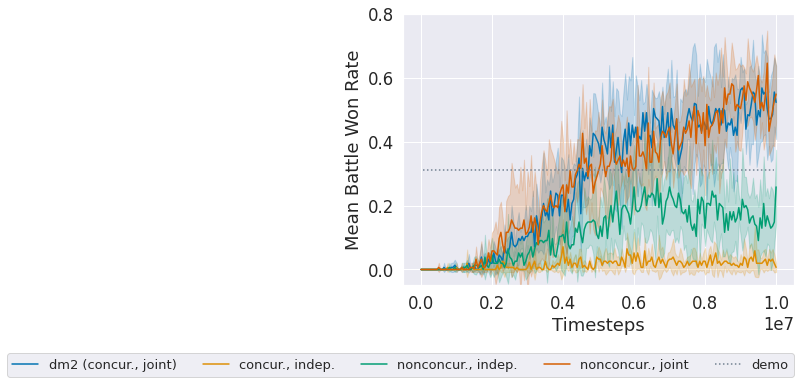

In [224]:
task = "5v6"
demo_ts= ["5m", "7m"]

for savename, experiments in {
        "5v6_ablations_exp_demo-ts=5m": experiments_ablations[task][demo_ts[0]], 
#         "5v6_ablations_exp_demo-ts=7m": experiments_ablations[task][demo_ts[1]]
        }.items():
    exp_dfs = gen_log_data(experiments)
    
    demo_ts = savename.split("_")[-1].split("=")[-1]
    plot_experiments(exp_dfs,                      
                     plot_title=None,
                     savename="legend", # savename, 
                     legend=True,
                     legend_cols=5,
                     custom_color_order=[0, 1, 2, 3],
                     demo_qual={f"demo": demo_win_rate[task][f"demo-ts={demo_ts}"]},
                     yaxis_lims=(-0.05, 0.80),
                     save=False, 
                     savedir="figures/")

## State-action Discriminator Ablations

In [ ]:
experiments_state_act_discrim = {
    "5v6": {
        "5m": {az
             "dm2": [
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same_seed=112358_01-17-22-37-49",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same_seed=119527_01-17-22-37-49",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same_seed=122529_01-17-22-37-49",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same_seed=1285842_01-17-22-37-49",
                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same_seed=78590_01-17-22-37-49"
             ],
            "state-act-discrim": [
                "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=112358_07-01-18-06-18",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=119527_07-01-18-06-18",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=122529_07-01-18-06-18",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=1285842_07-01-18-06-18",
#                 "ippo_sc2_rew-type=mixed-exp-ts=5m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=78590_07-01-18-06-18"
            ]                                                 
            },
        "7m": {
             "dm2": [
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same_seed=112358_01-18-23-01-27",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same_seed=119527_01-18-23-03-46",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same_seed=122529_01-18-23-03-46",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same_seed=1285842_01-18-23-01-27",
                 "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same_seed=78590_01-18-23-03-46"
             ],
            "state-act-discrim": [
                "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=112358_07-01-17-47-42",
                "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=119527_07-01-17-47-42",
                "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=122529_07-01-17-47-42",
                "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=1285842_07-01-17-47-42",
                "ippo_sc2_rew-type=mixed-exp-ts=7m-demos=concurrent-exp-policies=all-same-state-act-discr_seed=78590_07-01-17-47-42"
            ],
        }
    },
    "3sv4z": {
        "5m": {
             "dm2": [
                "ippo_sc2_rew-type=mixed-exp-ts=5m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=112358_01-25-13-32-18",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=119527_01-25-13-32-18",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=122529_01-25-13-32-18",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=1285842_01-25-13-32-18",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=78590_01-25-13-32-18"
             ],
            "state-act-discrim": [
                "ippo_sc2_rew-type=mixed-exp-ts=5m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same-state-act-discr_seed=112358_07-01-18-03-45",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same-state-act-discr_seed=119527_07-01-18-03-46",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same-state-act-discr_seed=122529_07-01-18-03-46",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same-state-act-discr_seed=1285842_07-01-18-03-46",
                "ippo_sc2_rew-type=mixed-exp-ts=5m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same-state-act-discr_seed=78590_07-01-18-03-45"
            ]                                                 
            },
        "6m": {
             "dm2": [
                "ippo_sc2_rew-type=mixed-exp-ts=6m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=112358_01-25-13-08-44",
                "ippo_sc2_rew-type=mixed-exp-ts=6m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=119527_01-25-13-08-44",
                "ippo_sc2_rew-type=mixed-exp-ts=6m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=122529_01-25-13-08-43",
                "ippo_sc2_rew-type=mixed-exp-ts=6m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=1285842_01-25-13-08-44",
                "ippo_sc2_rew-type=mixed-exp-ts=6m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same_seed=78590_01-25-13-08-44"
             ],
            "state-act-discrim": [
                "ippo_sc2_rew-type=mixed-exp-ts=6m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same-state-act-discr_seed=112358_07-01-17-54-39",
                "ippo_sc2_rew-type=mixed-exp-ts=6m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same-state-act-discr_seed=119527_07-01-17-54-39",
                "ippo_sc2_rew-type=mixed-exp-ts=6m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same-state-act-discr_seed=122529_07-01-17-54-39",
                "ippo_sc2_rew-type=mixed-exp-ts=6m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same-state-act-discr_seed=1285842_07-01-17-54-39",
                "ippo_sc2_rew-type=mixed-exp-ts=6m-gail-rew-coef=0.05-demos=concurrent-exp-policies=all-same-state-act-discr_seed=78590_07-01-17-54-39"
            ],
        }
    }

}

In [38]:
# ablations
# task = "3sv4z" 
task = "5v6"
# demo_ts= ["5m", "6m"] 
demo_ts = ["5m", "7m"]

# append base paths for ablations
ippo_base_path = f"/scratch/cluster/clw4542/marl_results/ippo_{task}/tb_logs"
ablation_log_files = [
            experiments_state_act_discrim[task][demo_ts[0]],
            experiments_state_act_discrim[task][demo_ts[1]]
                 ]

for experiment_set in ablation_log_files:
    for exp_name, paths in experiment_set.items():
        for i, path in enumerate(paths):
            experiment_set[exp_name][i] = os.path.join(ippo_base_path, path)
            

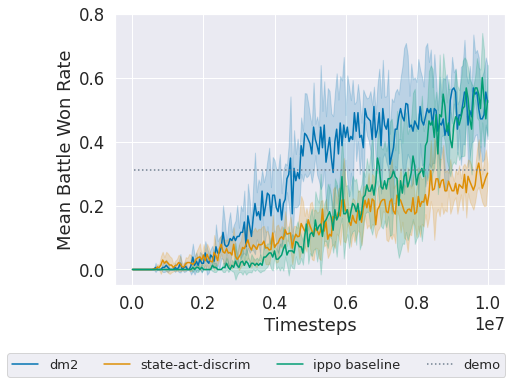

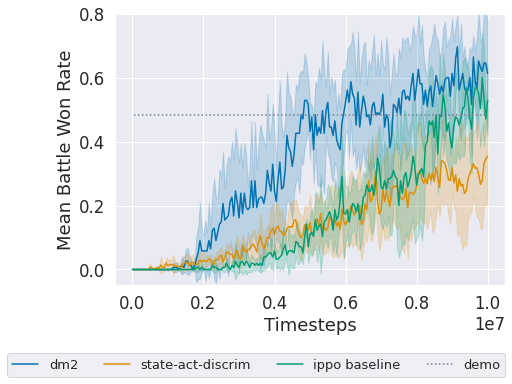

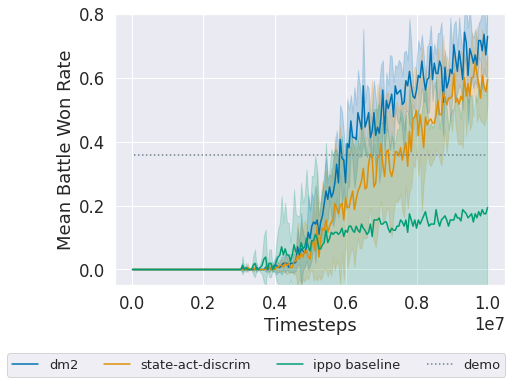

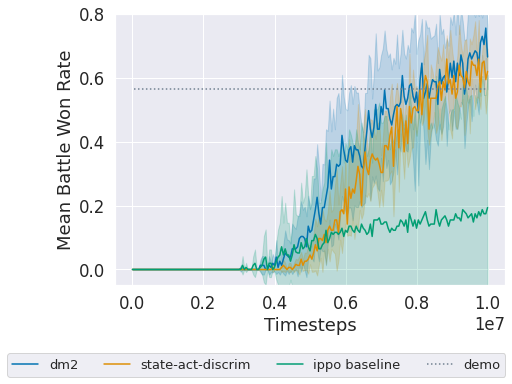

In [40]:
task_dict = {"5v6": ["5m", "7m"],
             "3sv4z": ["5m", "6m"]}

for task, demo_ts_list in task_dict.items():
    # read data
    ippo_base_path = f"/scratch/cluster/clw4542/marl_results/ippo_{task}/tb_logs"
    ablation_log_files = [experiments_state_act_discrim[task][ts] for ts in demo_ts_list]

    for experiment_set in ablation_log_files:
        for exp_name, paths in experiment_set.items():
            for i, path in enumerate(paths):
                experiment_set[exp_name][i] = os.path.join(ippo_base_path, path)
                
    # gen plots
    for ts in demo_ts_list:
        savename = f"{task}_ablations_exp_demo-ts={ts}"
        experiments = experiments_state_act_discrim[task][ts]

        exp_dfs = gen_log_data({**experiments,
                                **baselines["ippo"][task]
                               })

        demo_ts = savename.split("_")[-1].split("=")[-1]
        plot_experiments(exp_dfs,                      
                         plot_title=None,
                         savename="state-act-discrim_task=5v6", # savename, 
                         legend=True,
                         legend_cols=5,
                         custom_color_order=[0, 1, 2, 3],
                         demo_qual={f"demo": demo_win_rate[task][f"demo-ts={demo_ts}"]},
                         yaxis_lims=(-0.05, 0.80),
                         save=False)